
Лабораторная работа №4

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

- Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

- Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

- Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

- Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

- Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

- Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

В качестве датасета мы выбрали данные о клиентах оптового дистрибьютора. Данные содержат информацию о годовых тратах клиентов (в денежных единицах) на различные категории продуктов.

Датасет является многомерным и относится к предметной области бизнеса. Основные задачи анализа: классификация и кластеризация.

Признаки представляют собой целочисленные значения, кроме двух категориальных переменных. Всего в датасете 440 наблюдений и 8 признаков.

| Название признака | Роль    | Тип            | Описание                                     |
| ----------------- | ------- | -------------- | -------------------------------------------- |
| Channel           | Признак | Категориальный | Тип канала клиента (1 или 2)                 |
| Region            | Целевая | Категориальный | Регион клиента (1, 2, 3)                     |
| Fresh             | Признак | Целое число    | Годовые расходы на свежие продукты           |
| Milk              | Признак | Целое число    | Годовые расходы на молочные продукты         |
| Grocery           | Признак | Целое число    | Годовые расходы на бакалею                   |
| Frozen            | Признак | Целое число    | Годовые расходы на замороженные продукты     |
| Detergents_Paper  | Признак | Целое число    | Годовые расходы на моющие и бумажные изделия |
| Delicassen        | Признак | Целое число    | Годовые расходы на деликатесы                |


In [21]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from tabulate import tabulate
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, cophenet
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist


# Загрузка данных
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()

Дескриптивный анализ

Дескриптивный анализ показывает, что все признаки полные, пропусков нет, что упрощает последующую обработку данных.

Средние значения и медианы показывают значительную вариативность расходов: траты на свежие продукты («Fresh») в среднем выше всех остальных категорий, при этом разброс значений очень большой — максимальные расходы превышают 110 тысяч единиц, что заметно выше 75-го перцентиля, указывая на наличие нескольких крупных клиентов с экстремальными значениями. Остальные категории трат, такие как «Milk», «Grocery» и «Frozen», имеют умеренные средние значения и стандартные отклонения, при этом также наблюдаются высокие максимумы относительно медианы, что свидетельствует о выраженной положительной асимметрии распределений.

In [22]:
# Размерность и типы признаков
print("Размерность данных:", df.shape)
print("Информация по признакам:")
df.info()

# Статистическое описание
print(df.describe().T)

# Удаляем категориальные признаки, не влияющие на кластеризацию
df.drop(['Region', 'Channel'], axis=1, inplace=True)


Размерность данных: (440, 8)
Информация по признакам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
                  count          mean           std   min      25%     50%  \
Channel           440.0      1.322727      0.468052   1.0     1.00     1.0   
Region            440.0      2.543182      0.774272   1.0     2.00     3.0   
Fresh             440.0  12000.297727  12647.328865   3.0  3127.75  8504.0   
Milk              440.0   5796.265909   7

Оценка распределения переменных

Оценка распределения признаков показывает, что все количественные переменные далеки от нормального распределения. Тест Шапиро–Уилка для всех признаков отвергает гипотезу нормальности. Коэффициенты асимметрии (skewness) указывают на выраженную положительную асимметрию: значения всех признаков смещены вправо, что особенно заметно у «Delicassen», «Frozen» и «Milk», где смещение чрезвычайно сильное.

Коэффициенты эксцесса (kurtosis) у всех признаков очень высокие, что свидетельствует о тяжелых хвостах и наличии экстремальных значений, то есть распределения «острые» или «пикообразные». На практике это означает, что большинство клиентов имеют умеренные расходы, а небольшая группа — очень высокие, что создает сильные выбросы.

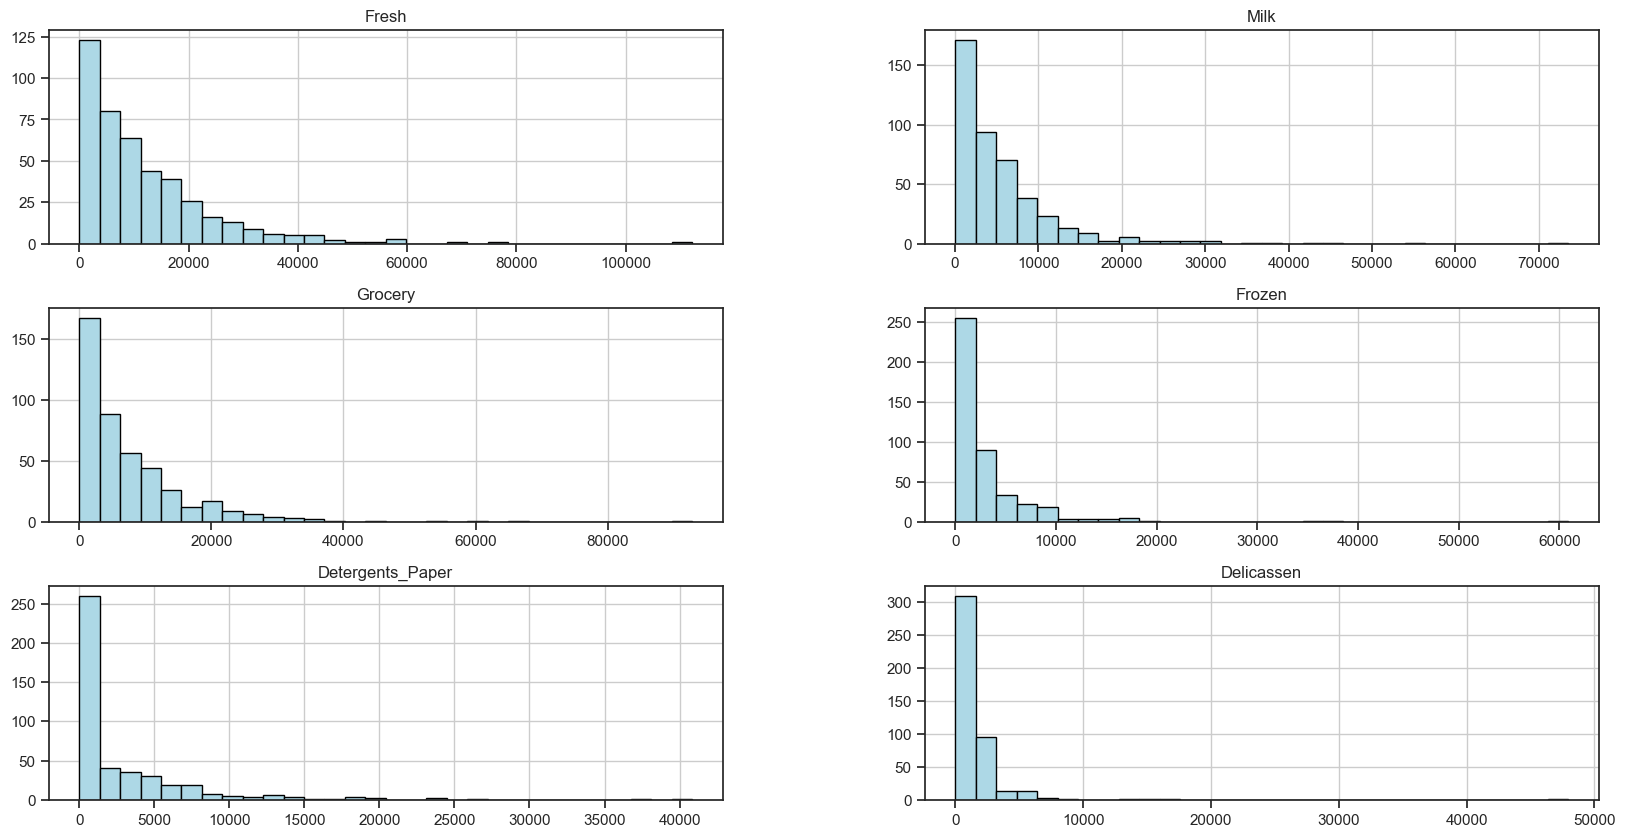

+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|     Variable     | Shapiro Test | Skewness Coefficient |   Skewness    | Kurtosis Coefficient |      Kurtosis      |
+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|      Fresh       |      No      |        2.5613        | Highly skewed |       11.5364        | Very flat or sharp |
|       Milk       |      No      |        4.0538        | Highly skewed |       24.6694        | Very flat or sharp |
|     Grocery      |      No      |        3.5874        | Highly skewed |       20.9147        | Very flat or sharp |
|      Frozen      |      No      |        5.9080        | Highly skewed |       54.6893        | Very flat or sharp |
| Detergents_Paper |      No      |        3.6319        | Highly skewed |       19.0095        | Very flat or sharp |
|    Delicassen    |      No      |       11.151

In [23]:
# Гистограммы
df.hist(figsize=(20,10), bins=30, color='lightblue', edgecolor='black')
plt.show()

skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Variable', 'Shapiro Test', 'Skewness Coefficient', 'Skewness', 'Kurtosis Coefficient', 'Kurtosis']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Highly skewed' if skewness[col] < -1 or skewness[col] > 1 else 'Symmetric or mildly skewed'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Very flat or sharp' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal or mildly flat'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Yes' if p_sh >= 0.05 else 'No'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

Логарифмическое преобразование для уменьшения асимметрии

Перед применением методов, предполагающих нормальное распределение или равномерный масштаб признаков, целесообразно выполнить логарифмическое преобразование, чтобы снизить влияние экстремальных значений.

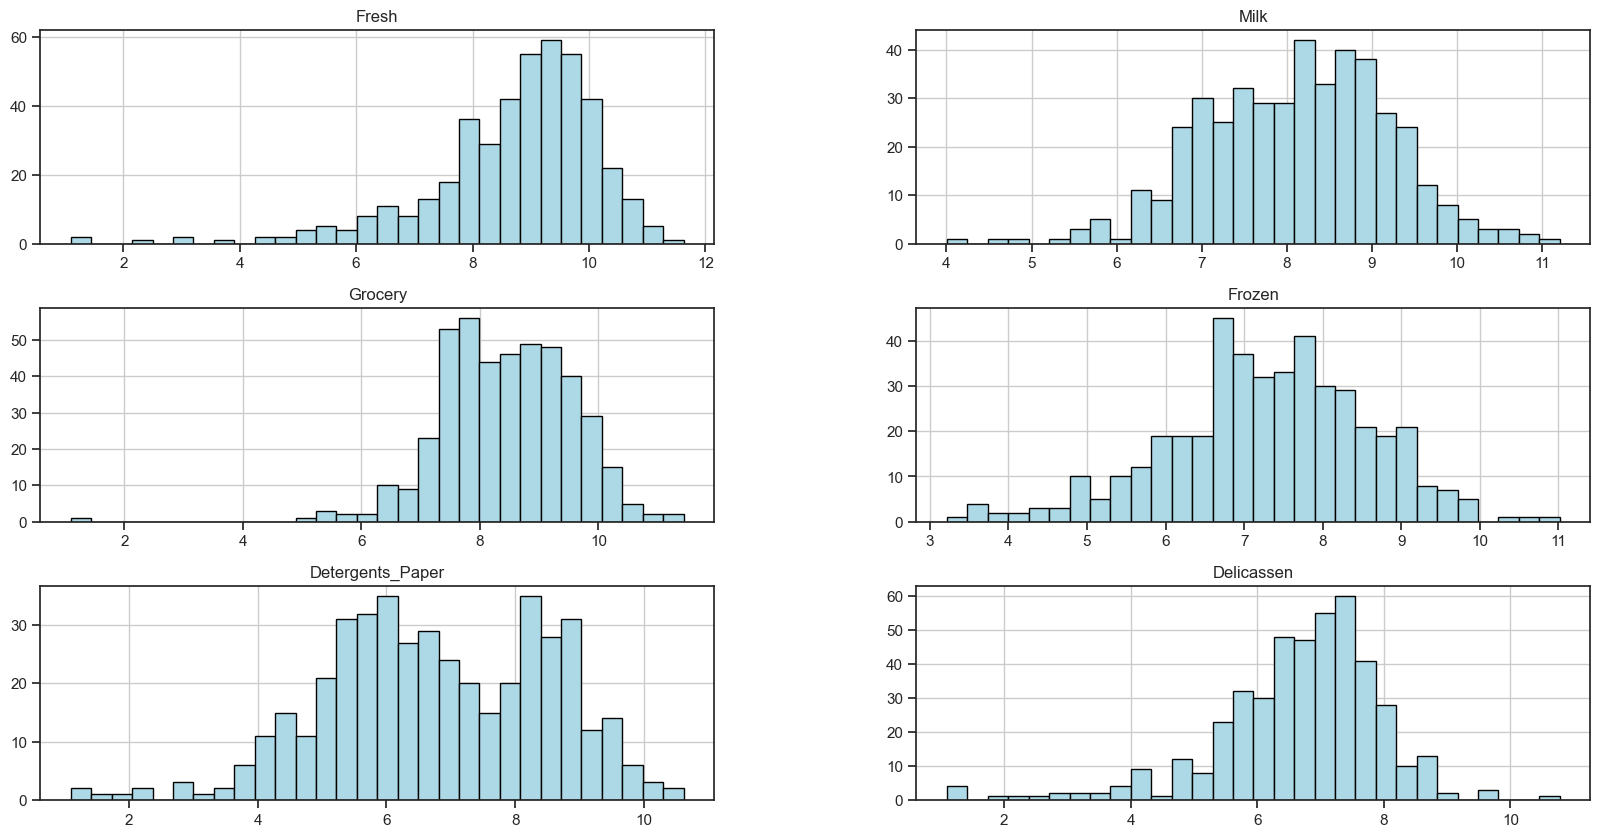

In [24]:
df = np.log(df)
df.hist(figsize=(20,10), bins=30, color='lightblue', edgecolor='black')
plt.show()

Оценка изменчивости признаков

Коэффициенты вариации признаков находятся в диапазоне примерно от 0,14 до 0,25, что указывает на умеренную относительную изменчивость данных. Это говорит о том, что признаки достаточно информативны для задач кластеризации: они не константны и содержат различия между клиентами, но при этом ни один признак не доминирует за счет слишком большой дисперсии.

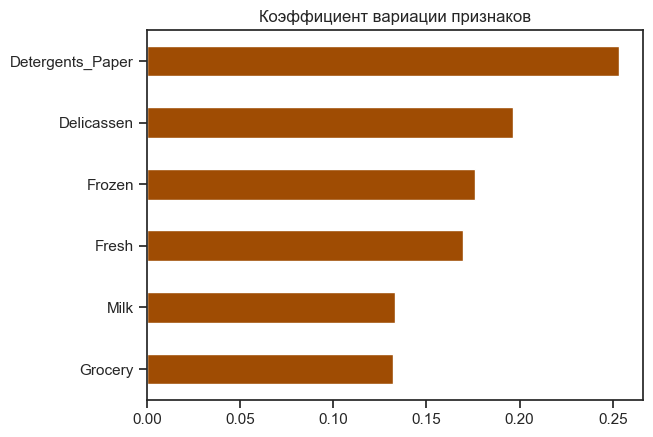

In [25]:
variability_coefficient = df.std() / df.mean()
sorted_vc = variability_coefficient.sort_values()
sorted_vc.plot.barh(x='Variables', y='Variability Coefficient')
plt.title("Коэффициент вариации признаков")
plt.show()

Для проверки осмысленности кластеризации был рассчитан Hopkins statistic, который позволяет оценить, существует ли в данных естественная кластерная структура. Для нашего набора данных значение статистики составило 1.000, что указывает на наличие ярко выраженных кластеров. Значение, близкое к 1, подтверждает, что точки распределены не случайным образом, а формируют отчетливые группы. Таким образом, применение методов кластеризации к выбранному датасету является оправданным и целесообразным.

In [26]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins(X, m=0.1):
    X = np.array(X)
    n, d = X.shape
    m = int(m*n)
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    
    # Случайные точки из исходного датасета
    rand_X_indices = np.random.choice(n, m, replace=False)
    X_m = X[rand_X_indices]
    
    # Генерация случайных точек в пространстве признаков
    X_min, X_max = X.min(axis=0), X.max(axis=0)
    U_m = np.random.uniform(X_min, X_max, (m,d))
    
    # Вычисление расстояний до ближайших соседей
    W = np.sum(nbrs.kneighbors(X_m, return_distance=True)[0])
    U = np.sum(nbrs.kneighbors(U_m, return_distance=True)[0])
    
    H = U / (U + W)
    return H

# Применение к масштабированным данным
hopkins_stat = hopkins(df)
print(f"Hopkins statistic: {hopkins_stat:.3f}")


Hopkins statistic: 1.000


Проверка выбросов и корреляций

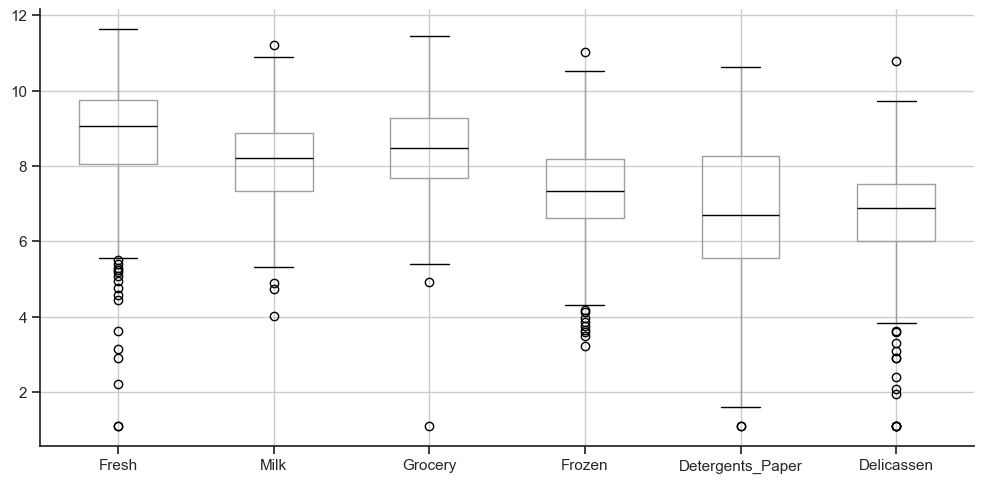

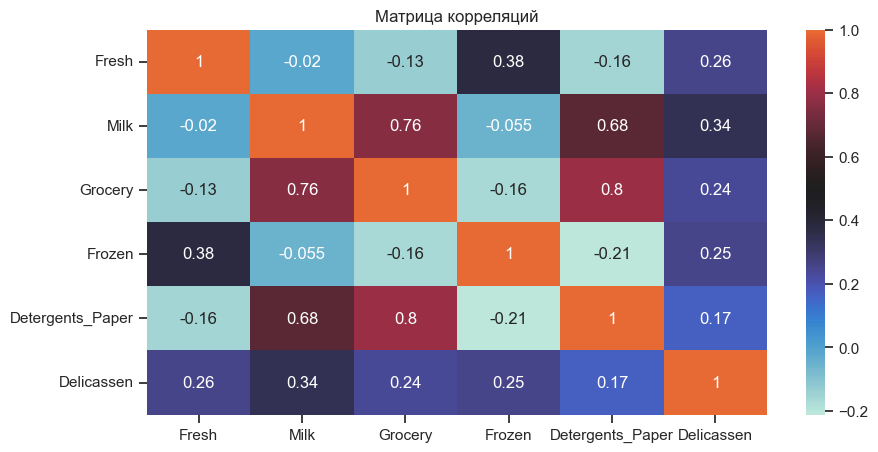

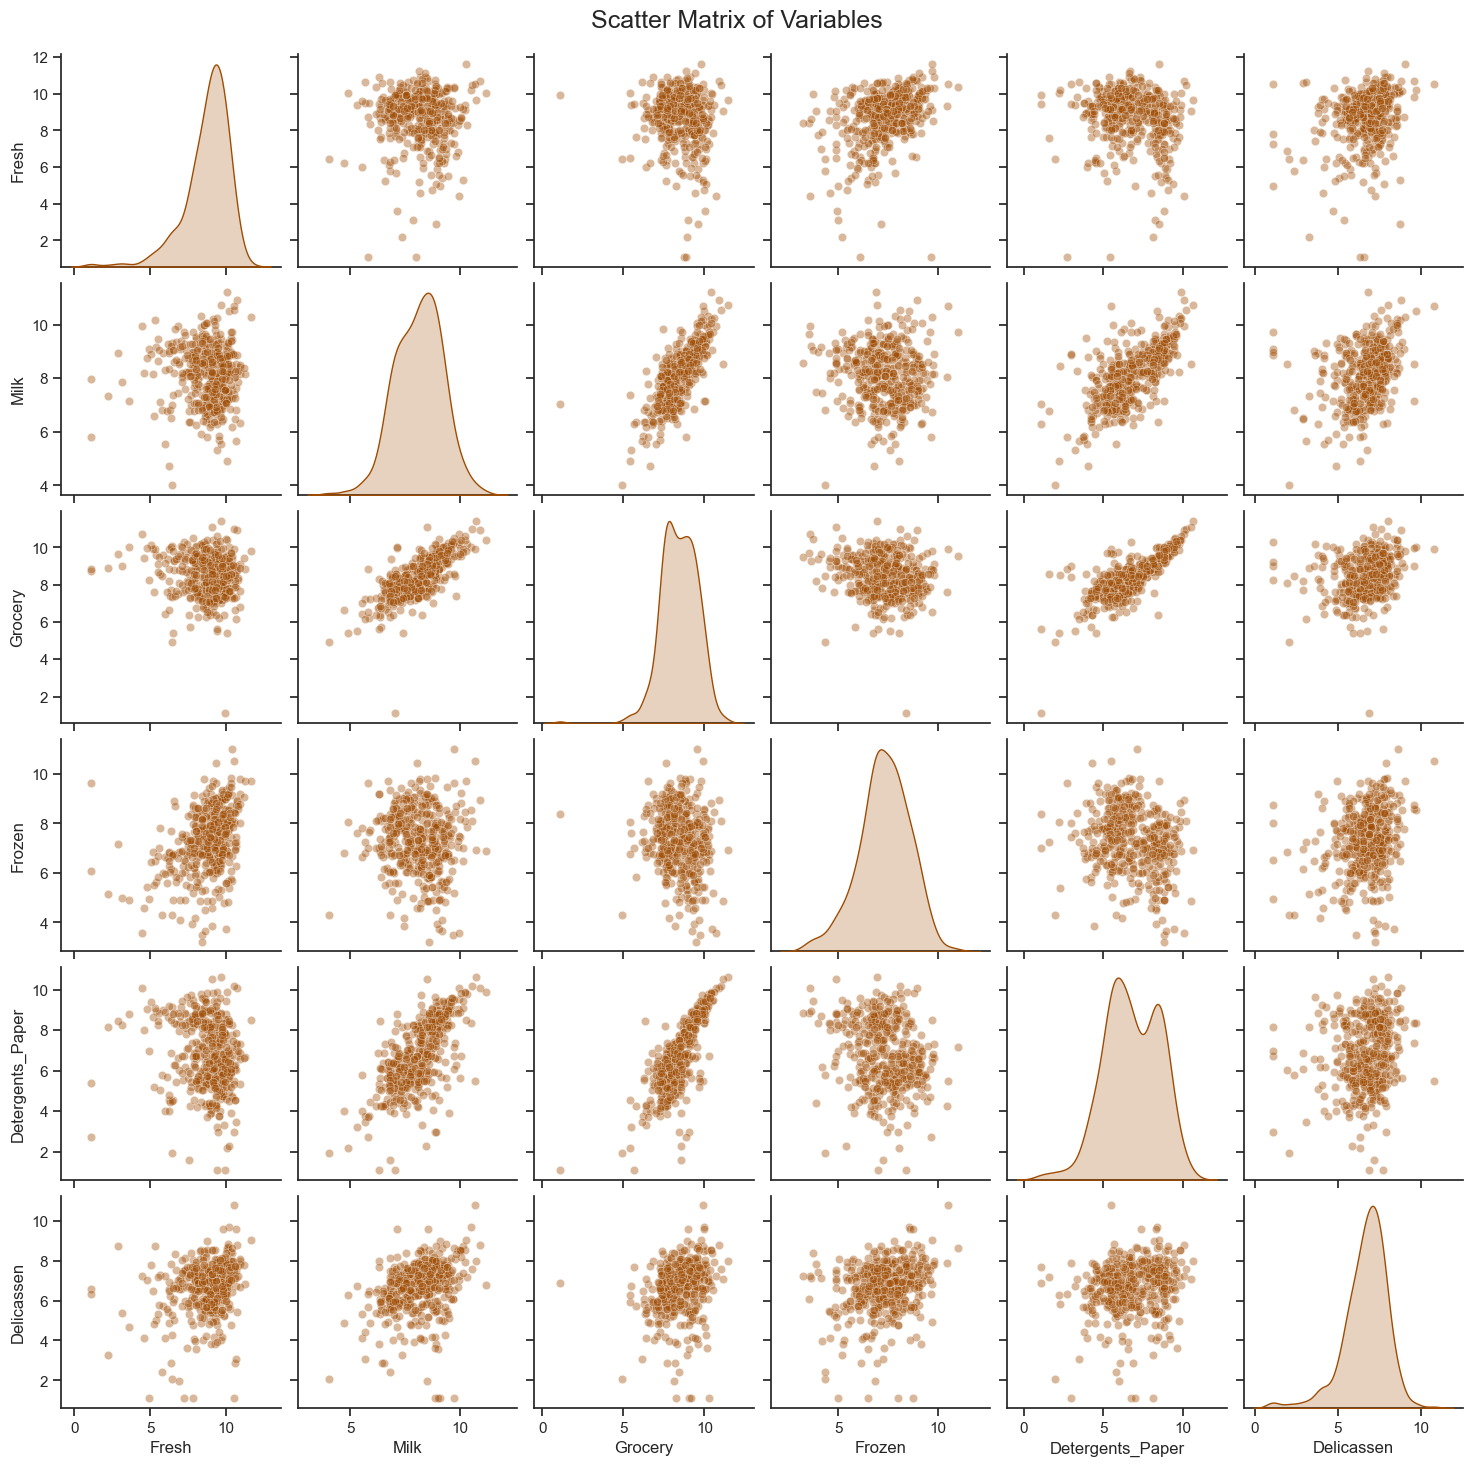

In [27]:
# Boxplot для визуальной оценки выбросов
plt.figure(figsize=(10,5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

# Матрица корреляций
corr = df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, center=0.5, annot=True)
plt.title('Матрица корреляций')
plt.show()

# Scatter Matrix для визуальной оценки структуры данных
sns.set(style='ticks', palette=sns.color_palette(["#9f4c03"]))
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha':0.4})
plt.subplots_adjust(top=0.95)
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)
plt.show()

Выбросы

В рамках подготовки данных была проведена проверка на наличие выбросов для всех количественных признаков. Выбросы определялись с использованием интерквартильного размаха (IQR): значения, выходящие за пределы Q1−1.5\*IQR и Q3+1.5\*IQR, рассматривались как выбросы. В результате анализа были выявлены выбросы в признаках «Fresh» (16 значений), «Milk» (4 значения), «Grocery» (2 значения), «Frozen» (10 значений), «Detergents_Paper» (2 значения) и «Delicassen» (14 значений).

Для снижения влияния экстремальных значений на последующую кластеризацию все выбросы были «усечены» до границ интерквартильного размаха: значения ниже нижней границы заменялись на  Q1−1.5\*IQR, а значения выше верхней границы — на Q3+1.5\*IQR. После применения этой процедуры распределения признаков стали более компактными и пригодными для кластеризации, при этом сохранялась вариативность данных, необходимая для выявления различий между клиентами.

Визуализация распределений после обработки с помощью boxplot показывает отсутствие экстремальных выбросов и более равномерное распределение значений по всем признакам.

Fresh (16 выбросов): [4.44265126 2.19722458 5.38907173 1.09861229 3.13549422 4.94164242
 5.29831737 5.19295685 2.89037176 5.08140436 5.49306144 1.09861229
 4.76217393 5.24702407 3.61091791 4.57471098]
Milk (4 выбросов): [11.20501347  4.71849887  4.00733319  4.8978398 ]
Grocery (2 выбросов): [1.09861229 4.91998093]
Frozen (10 выбросов): [ 3.49650756  3.63758616  3.58351894  3.73766962  3.95124372  4.11087386
 11.01647929  3.21887582  3.8501476   4.17438727]
Detergents_Paper (2 выбросов): [1.09861229 1.09861229]
Delicassen (14 выбросов): [ 3.29583687  1.09861229  1.09861229  3.58351894  1.09861229  2.07944154
 10.77776808  2.39789527  1.09861229  2.89037176  1.94591015  2.89037176
  3.09104245  3.61091791]


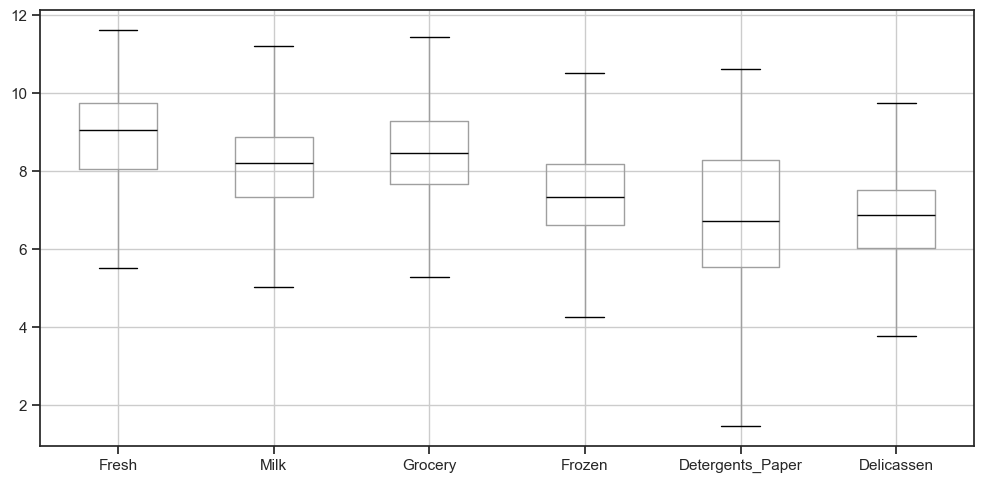

In [28]:
outliers = {}
for col in df.columns:
    q25, q75 = np.percentile(df[col], [25,75])
    iqr = q75 - q25
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    outlier_values = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if not outlier_values.empty:
        outliers[col] = outlier_values.values

for col, values in outliers.items():
    print(f'{col} ({len(values)} выбросов): {values}')

# удаление выбросов
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25,75])
    iqr = q75 - q25
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    df.loc[df[i] < lower_bound, i] = lower_bound
    df.loc[df[i] > upper_bound, i] = upper_bound

plt.figure(figsize=(10,5))
df.boxplot()
plt.tight_layout()
plt.show()

На диаграммах рассеяния визуально можно выделить два-три кластера, но не более.

Форма кластеров не идеально сферическая, скорее близкая к эллиптической. Границы кластеров плавные, без резких разделений или зон высокой плотности, что делает данные плохо подходящими для алгоритмов, ориентированных на плотность, таких как DBSCAN. В то же время, K-Means подходит для выделения основных групп, так как кластеры не имеют сложных изгибов и приблизительно равномерно распределены. Gaussian Mixture (GMM) выбран как метод, учитывающий возможную эллиптическую форму кластеров и позволяющий различать группы с разной ковариационной структурой. Алгоритмы на основе плотности оказались бы менее устойчивыми, так как распределение точек не демонстрирует резко выраженных плотных областей или явного шума.

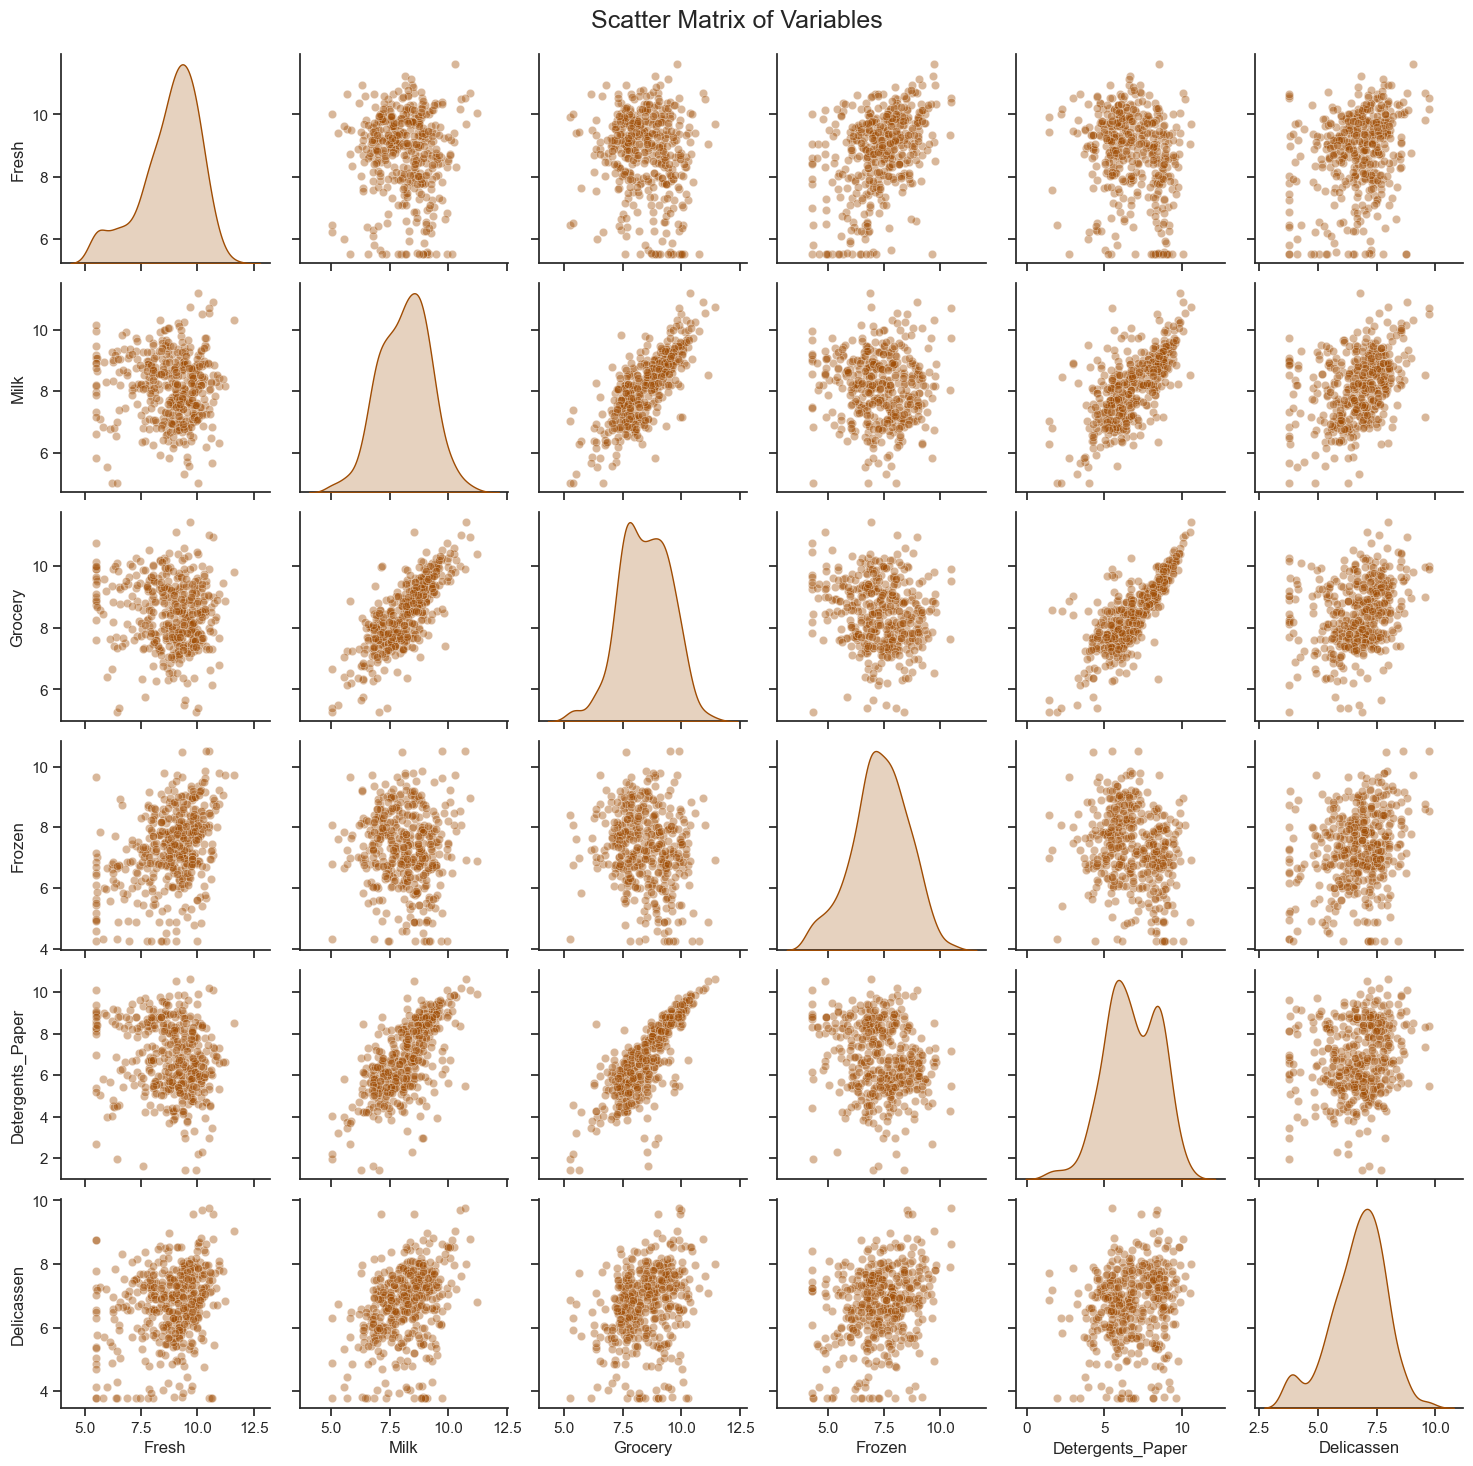

In [29]:
# Scatter Matrix после удаления выбросов
sns.set(style='ticks', palette=sns.color_palette(["#9f4c03"]))
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha':0.4})
plt.subplots_adjust(top=0.95)
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)
plt.show()

Проверка пропусков и дубликатов

Пропусков и дубликатов не было выявлено.

In [30]:
print("Пропущенные значения по столбцам:\n", df.isnull().sum())
print("Количество дубликатов:", df.duplicated().sum())

Пропущенные значения по столбцам:
 Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Количество дубликатов: 0


Стандартизация данных

In [31]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

K-Means

Для определения оптимального числа кластеров была проведена оценка качества кластеризации с использованием алгоритма k-means на масштабированных данных. Рассматривался диапазон количества кластеров от 2 до 10. В качестве метрик качества применялись силуэт (Silhouette Score), индекс Девиса–Болдина (Davies-Bouldin Score) и индекс Калински–Харабаза (Calinski-Harabasz Score).

Результаты анализа показали, что по метрике силуэта оптимальное количество кластеров равно 2, по индексу Калински–Харабаза также 2, а по индексу Девиса–Болдина — 3. Поскольку две из трёх метрик указывают на k=2, это значение можно рассматривать как оптимальное для выделения основных групп клиентов.

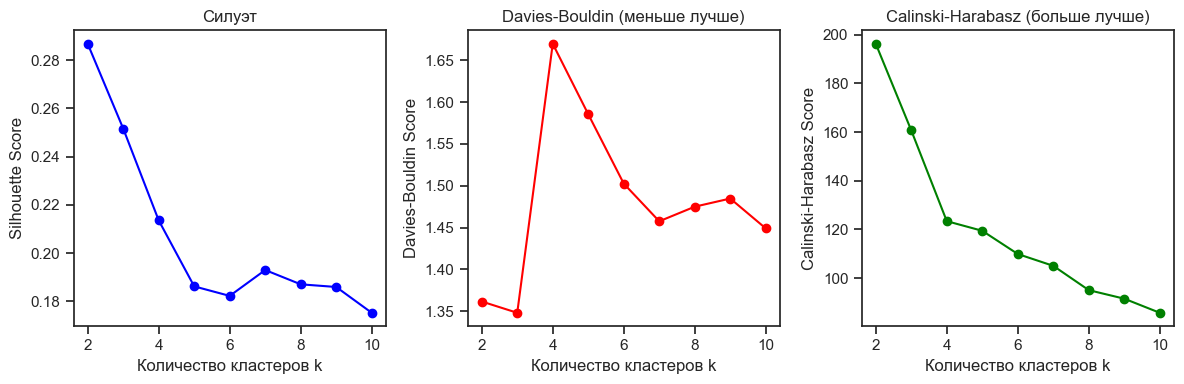

Оптимальное k по Silhouette: 2
Оптимальное k по Davies-Bouldin: 3
Оптимальное k по Calinski-Harabasz: 2


In [32]:
# Диапазон количества кластеров для исследования
k_range = range(2, 11)

# Списки для хранения метрик
sil_scores = []
db_scores = []
ch_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_scaled)
    
    sil_scores.append(silhouette_score(df_scaled, labels))
    db_scores.append(davies_bouldin_score(df_scaled, labels))
    ch_scores.append(calinski_harabasz_score(df_scaled, labels))

# Визуализация зависимости метрик от k
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(k_range, sil_scores, 'o-', color='blue')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Силуэт')

plt.subplot(1,3,2)
plt.plot(k_range, db_scores, 'o-', color='red')
plt.xlabel('Количество кластеров k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin (меньше лучше)')

plt.subplot(1,3,3)
plt.plot(k_range, ch_scores, 'o-', color='green')
plt.xlabel('Количество кластеров k')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz (больше лучше)')

plt.tight_layout()
plt.show()

# Оптимальное k по метрикам
best_sil = k_range[sil_scores.index(max(sil_scores))]
best_db = k_range[db_scores.index(min(db_scores))]
best_ch = k_range[ch_scores.index(max(ch_scores))]

print(f"Оптимальное k по Silhouette: {best_sil}")
print(f"Оптимальное k по Davies-Bouldin: {best_db}")
print(f"Оптимальное k по Calinski-Harabasz: {best_ch}")

После определения оптимального числа кластеров, равного двум, была выполнена кластеризация клиентов с использованием алгоритма k-means. Алгоритм был применён к масштабированным данным, что позволило признакам с разными масштабами оказывать равное влияние на формирование кластеров. В результате каждому клиенту был присвоен метка кластера, а центры кластеров были рассчитаны для анализа типовых профилей клиентов.

Для наглядной оценки структуры кластеров были построены графические визуализации. В двумерном представлении (по первым двум признакам после масштабирования) кластеры разделены относительно компактно, что позволяет различить две основные группы клиентов. Трёхмерная визуализация, учитывающая три признака, подтверждает выделение двух устойчивых групп и демонстрирует пространственное разделение клиентов по расходам на разные категории продуктов.

Оптимальное количество кластеров: 2


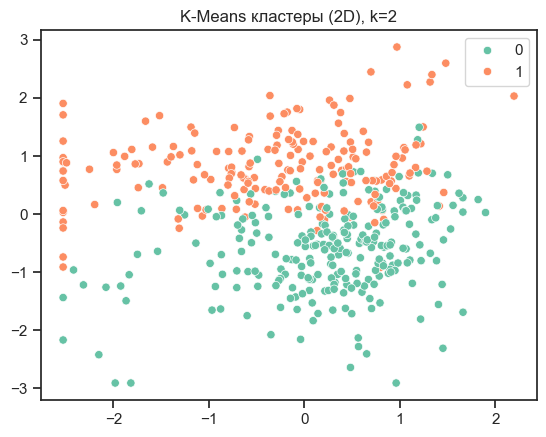

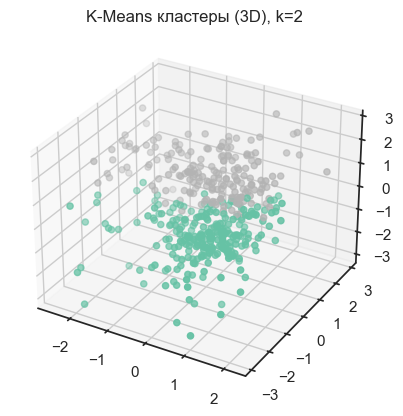

In [33]:
optimal_k = 2
print(f"Оптимальное количество кластеров: {optimal_k}")

# K-Means с оптимальным k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

# Визуализация кластеров в 2D
sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=labels_kmeans, palette='Set2')
plt.title(f"K-Means кластеры (2D), k={optimal_k}")
plt.show()

# Визуализация кластеров в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:,0], df_scaled[:,1], df_scaled[:,2], c=labels_kmeans, cmap='Set2')
plt.title(f"K-Means кластеры (3D), k={optimal_k}")
plt.show()


Gaussian Mixture

Для альтернативного подхода к кластеризации был использован метод Gaussian Mixture (GMM), который моделирует данные как смесь многомерных нормальных распределений. Для выбора оптимального числа кластеров применялись информационные критерии BIC и AIC, рассматривая диапазон от 2 до 10 компонентов. Анализ показал, что минимальное значение BIC достигается при k=2, что совпадает с выбором числа кластеров, полученным ранее с помощью алгоритма k-means.

С использованием оптимального числа кластеров был выполнен разбиение клиентов на две группы. Визуализация кластеров в двумерном и трёхмерном пространстве демонстрирует четкое разделение групп и подтверждает выделение двух устойчивых сегментов клиентов по расходам на различные категории продуктов.

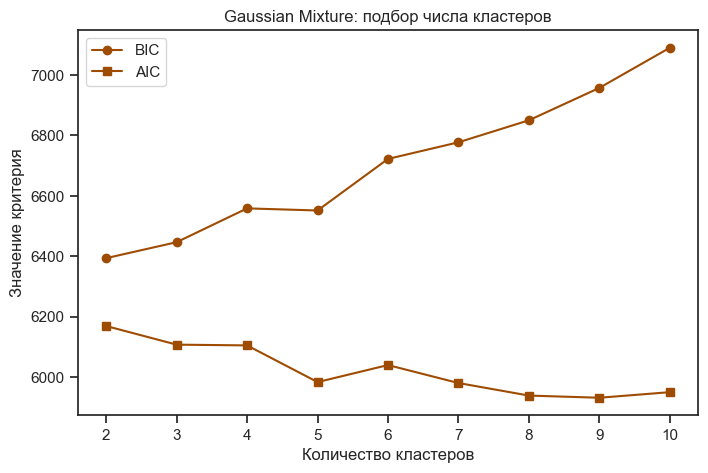

Оптимальное количество кластеров для GMM: 2


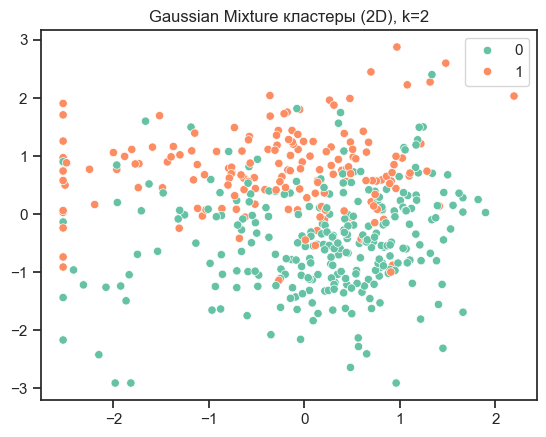

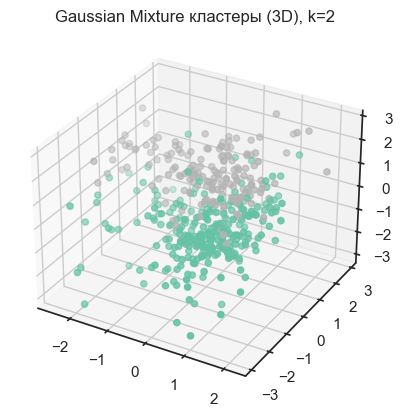

In [34]:
# Подбор оптимального числа кластеров с помощью BIC/AIC
n_components = range(2, 11)
bic_scores = []
aic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))
    aic_scores.append(gmm.aic(df_scaled))

# Визуализация BIC и AIC
plt.figure(figsize=(8,5))
plt.plot(n_components, bic_scores, label='BIC', marker='o')
plt.plot(n_components, aic_scores, label='AIC', marker='s')
plt.xlabel('Количество кластеров')
plt.ylabel('Значение критерия')
plt.title('Gaussian Mixture: подбор числа кластеров')
plt.legend()
plt.show()

# Оптимальное количество кластеров выбираем по минимальному BIC
optimal_gmm_k = n_components[np.argmin(bic_scores)]
print(f"Оптимальное количество кластеров для GMM: {optimal_gmm_k}")

# Кластеризация с оптимальным числом кластеров
gmm = GaussianMixture(n_components=optimal_gmm_k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

# Визуализация кластеров в 2D
sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=gmm_labels, palette='Set2')
plt.title(f"Gaussian Mixture кластеры (2D), k={optimal_gmm_k}")
plt.show()

# Визуализация кластеров в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:,0], df_scaled[:,1], df_scaled[:,2], c=gmm_labels, cmap='Set2')
plt.title(f"Gaussian Mixture кластеры (3D), k={optimal_gmm_k}")
plt.show()


Оценка качества кластеризации

Внутренние метрики оценивают качество кластеризации, не используя внешние метки. Silhouette, Davies-Bouldin и Calinski-Harabasz смотрят на то, как плотны кластеры внутри и насколько они различимы между собой. 

Silhouette показывает среднее, насколько объекты внутри кластера ближе друг к другу, чем к соседним кластерам: чем ближе к 1, тем лучше, у нас K-Means - 0.287, GMM - 0.263, то есть оба метода дают слабую, но заметную структуру. 

Davies-Bouldin измеряет отношение внутрикластерной дисперсии к расстоянию между центрами: меньше - лучше, у K-Means 1.361, у GMM 1.410, это говорит, что кластеры K-Means чуть более разнесены и менее перекрываются. 

Calinski-Harabasz оценивает отношение вариации между кластерами к вариации внутри: выше - лучше, K-Means 196.293, GMM 171.584, опять же K-Means показывает чуть более выраженные кластеры.

Центры кластеров показывают средние значения признаков внутри каждого кластера. В K-Means первый кластер характеризуется меньшими значениями всех категорий по сравнению со вторым, особенно по Milk и Grocery, а второй кластер больше по этим категориям. 

Расстояние между центрами (2.75) показывает, насколько кластеры отличаются, а средние внутрикластерные расстояния (1.815 и 1.935) показывают, насколько объекты внутри кластера близки к центру: чем меньше, тем плотнее кластер. В GMM центры очень похожи, расстояние между ними чуть меньше (2.6), средние внутрикластерные расстояния около 1.8–1.95, что говорит о схожей плотности, но распределение кластеров немного менее чёткое.

В целом, K-Means формирует немного более выраженные и разнесённые кластеры, GMM - чуть более перекрытые, с похожей внутрикластерной плотностью. Метрики подтверждают, что различия между этими подходами есть, но они не слишком большие.

In [35]:
print("Внутренние метрики")

# K-Means
sil_kmeans = silhouette_score(df_scaled, labels_kmeans)
db_kmeans = davies_bouldin_score(df_scaled, labels_kmeans)
ch_kmeans = calinski_harabasz_score(df_scaled, labels_kmeans)
print(f"\nK-Means: Silhouette={sil_kmeans:.3f}, Davies-Bouldin={db_kmeans:.3f}, Calinski-Harabasz={ch_kmeans:.3f}")

# Gaussian Mixture
sil_gmm = silhouette_score(df_scaled, gmm_labels)
db_gmm = davies_bouldin_score(df_scaled, gmm_labels)
ch_gmm = calinski_harabasz_score(df_scaled, gmm_labels)
print(f"\nGMM: Silhouette={sil_gmm:.3f}, Davies-Bouldin={db_gmm:.3f}, Calinski-Harabasz={ch_gmm:.3f}")

# Центры кластеров (K-Means)
centers_orig = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(centers_orig, columns=df.columns)
print("\nЦентры кластеров K-Means:")
print(centers_df)

# Расстояния между кластерами (для K-Means)
centers = kmeans.cluster_centers_
dist_matrix = cdist(centers, centers)
print("\nРасстояния между центрами кластеров K-Means:")
print(np.round(dist_matrix, 2))

# Внутрикластерные расстояния (среднее расстояние от точек до центра)
intra_distances = []
for i in range(optimal_k):
    points = df_scaled[labels_kmeans == i]
    center = centers[i]
    intra_dist = np.mean(np.linalg.norm(points - center, axis=1))
    intra_distances.append(intra_dist)

print("\nСредние внутрикластерные расстояния K-Means:")
for i, d in enumerate(intra_distances):
    print(f"Кластер {i}: {d:.3f}")


# GMM
gmm_centers = gmm.means_
gmm_centers_orig = scaler.inverse_transform(gmm_centers)
gmm_centers_df = pd.DataFrame(gmm_centers_orig, columns=df.columns)
print("\nЦентры кластеров GMM:")
print(gmm_centers_df)

# Расстояния между центрами GMM
dist_matrix_gmm = cdist(gmm_centers, gmm_centers)
print("\nРасстояния между центрами кластеров GMM:")
print(np.round(dist_matrix_gmm, 2))

# Внутрикластерные расстояния для GMM
intra_distances_gmm = []
for i in range(gmm.n_components):
    points = df_scaled[gmm_labels == i]
    center = gmm_centers[i]
    intra_dist = np.mean(np.linalg.norm(points - center, axis=1))
    intra_distances_gmm.append(intra_dist)

print("\nСредние внутрикластерные расстояния GMM:")
for i, d in enumerate(intra_distances_gmm):
    print(f"Кластер {i}: {d:.3f}")

Внутренние метрики

K-Means: Silhouette=0.287, Davies-Bouldin=1.361, Calinski-Harabasz=196.293

GMM: Silhouette=0.263, Davies-Bouldin=1.410, Calinski-Harabasz=171.584

Центры кластеров K-Means:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  9.074036  7.473857  7.745980  7.641763          5.668188    6.498763
1  8.396600  8.996112  9.397129  6.866920          8.288110    6.982801

Расстояния между центрами кластеров K-Means:
[[0.   2.75]
 [2.75 0.  ]]

Средние внутрикластерные расстояния K-Means:
Кластер 0: 1.815
Кластер 1: 1.935

Центры кластеров GMM:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  9.017409  7.649388  7.880203  7.644600          5.732947    6.582865
1  8.405614  8.897260  9.381337  6.767186          8.504309    6.905323

Расстояния между центрами кластеров GMM:
[[0.  2.6]
 [2.6 0. ]]

Средние внутрикластерные расстояния GMM:
Кластер 0: 1.947
Кластер 1: 1.827


Для оценки качества кластеризации относительно известных категориальных признаков были использованы внешние метрики: Adjusted Rand Index (ARI) и Normalized Mutual Information (NMI).

При сравнении кластеров с признаком Channel наблюдается умеренная согласованность: ARI для K-Means равен 0.501, для GMM - 0.552, NMI соответственно 0.431 и 0.453. Это говорит о том, что выявленные кластеры частично отражают тип канала клиента, что ожидаемо, так как различия в расходах клиентов связаны с каналом продаж.

При сравнении кластеров с признаком Region значения внешних метрик близки к нулю (ARI = 0, NMI = 0), что свидетельствует о практически полном отсутствии связи между выделенными кластерами и региональной принадлежностью клиентов. Иными словами, кластеризация по расходам не выделяет группы по географическому признаку.

Низкие значения здесь не означают «плохую» кластеризацию, а лишь то, что сегменты, выявленные по расходам, не совпадают с заранее заданными категориями Channel/Region.

In [36]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans_labels = labels_kmeans
gmm_labels = gmm_labels

# Внешние метрики относительно Channel
ari_channel_kmeans = adjusted_rand_score(data['Channel'], kmeans_labels)
nmi_channel_kmeans = normalized_mutual_info_score(data['Channel'], kmeans_labels)

ari_channel_gmm = adjusted_rand_score(data['Channel'], gmm_labels)
nmi_channel_gmm = normalized_mutual_info_score(data['Channel'], gmm_labels)

# Внешние метрики относительно Region
ari_region_kmeans = adjusted_rand_score(data['Region'], kmeans_labels)
nmi_region_kmeans = normalized_mutual_info_score(data['Region'], kmeans_labels)

ari_region_gmm = adjusted_rand_score(data['Region'], gmm_labels)
nmi_region_gmm = normalized_mutual_info_score(data['Region'], gmm_labels)

print("Channel vs K-Means: ARI =", round(ari_channel_kmeans, 3), ", NMI =", round(nmi_channel_kmeans, 3))
print("Channel vs GMM: ARI =", round(ari_channel_gmm, 3), ", NMI =", round(nmi_channel_gmm, 3))
print("Region vs K-Means: ARI =", round(ari_region_kmeans, 3), ", NMI =", round(nmi_region_kmeans, 3))
print("Region vs GMM: ARI =", round(ari_region_gmm, 3), ", NMI =", round(nmi_region_gmm, 3))


Channel vs K-Means: ARI = 0.501 , NMI = 0.431
Channel vs GMM: ARI = 0.622 , NMI = 0.515
Region vs K-Means: ARI = -0.008 , NMI = 0.002
Region vs GMM: ARI = -0.015 , NMI = 0.006


Изменим гиперпараметры

Сравнение показывает, что при полном типе ковариации (full) модель достигает наилучшего качества кластеризации с точки зрения внутренних метрик: оптимальное число компонентов равно 2, силуэт самый высокий, Davies-Bouldin минимальный, а Calinski-Harabasz максимальный. Это отражает естественную структуру данных с двумя явными кластерами.

При использовании ограниченных типов ковариации (tied, diag, spherical) алгоритм вынужден увеличивать число кластеров, чтобы компенсировать ограничения формы: кластеры становятся менее компактными и различимыми, что подтверждается снижением силуэта, ростом Davies-Bouldin и падением Calinski-Harabasz. Чем более строгие ограничения на ковариацию, тем выше оптимальное число компонентов и хуже внутренние метрики, что указывает на менее адекватное моделирование реальной структуры данных.


Covariance type: full
Optimal components (BIC): 2
Silhouette: 0.263
Davies-Bouldin: 1.410
Calinski-Harabasz: 171.584


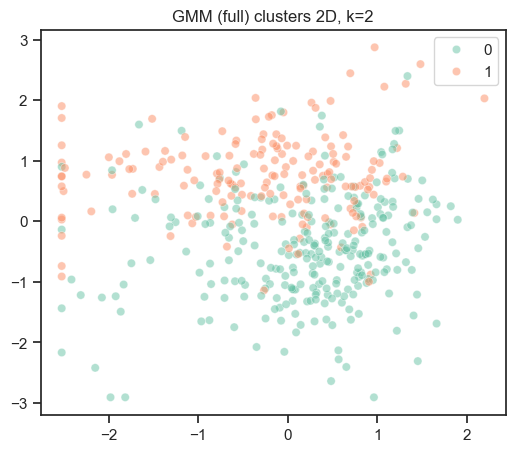


Covariance type: tied
Optimal components (BIC): 7
Silhouette: 0.198
Davies-Bouldin: 1.432
Calinski-Harabasz: 64.200


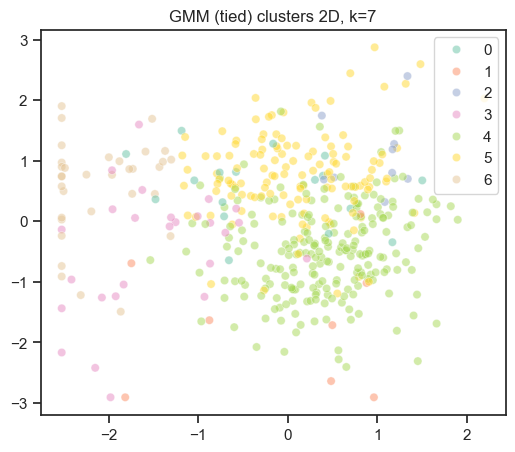


Covariance type: diag
Optimal components (BIC): 9
Silhouette: 0.113
Davies-Bouldin: 1.715
Calinski-Harabasz: 71.711


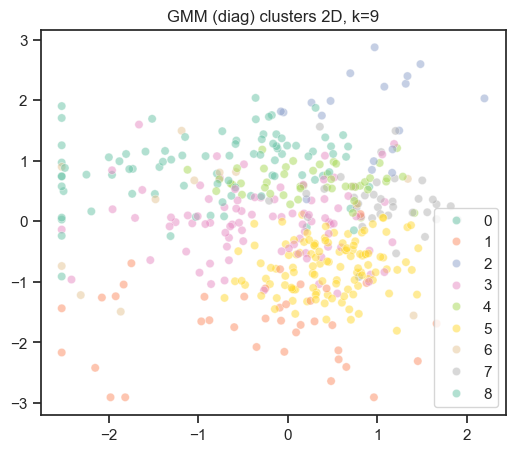


Covariance type: spherical
Optimal components (BIC): 10
Silhouette: 0.190
Davies-Bouldin: 1.492
Calinski-Harabasz: 81.948


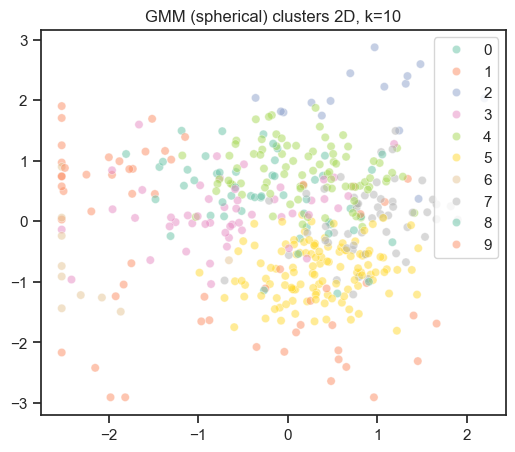

In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

cov_types = ['full', 'tied', 'diag', 'spherical']
results = {}

for cov_type in cov_types:
    bic_scores = []
    aic_scores = []
    sil_scores = []
    db_scores = []
    ch_scores = []

    for n in n_components:
        gmm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
        labels = gmm.fit_predict(df_scaled)

        bic_scores.append(gmm.bic(df_scaled))
        aic_scores.append(gmm.aic(df_scaled))
        sil_scores.append(silhouette_score(df_scaled, labels))
        db_scores.append(davies_bouldin_score(df_scaled, labels))
        ch_scores.append(calinski_harabasz_score(df_scaled, labels))

    optimal_k_bic = n_components[np.argmin(bic_scores)]
    optimal_k_aic = n_components[np.argmin(aic_scores)]
    results[cov_type] = {
        'bic_scores': bic_scores,
        'aic_scores': aic_scores,
        'sil_scores': sil_scores,
        'db_scores': db_scores,
        'ch_scores': ch_scores,
        'optimal_k_bic': optimal_k_bic,
        'optimal_k_aic': optimal_k_aic
    }

    # Кластеризация с оптимальным BIC
    gmm_opt = GaussianMixture(n_components=optimal_k_bic, covariance_type=cov_type, random_state=42)
    gmm_labels = gmm_opt.fit_predict(df_scaled)

    print(f"\nCovariance type: {cov_type}")
    print(f"Optimal components (BIC): {optimal_k_bic}")
    print(f"Silhouette: {silhouette_score(df_scaled, gmm_labels):.3f}")
    print(f"Davies-Bouldin: {davies_bouldin_score(df_scaled, gmm_labels):.3f}")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(df_scaled, gmm_labels):.3f}")

    # Визуализация в 2D
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=gmm_labels, palette='Set2', alpha=0.5)
    plt.title(f"GMM ({cov_type}) clusters 2D, k={optimal_k_bic}")
    plt.show()


PCA-визуализация

Для наглядного сравнения результатов кластеризации был выполнен анализ в двумерном пространстве с помощью метода главных компонент (PCA). PCA позволил сократить размерность данных до двух компонент, сохранив при этом большую часть вариативности признаков, что упрощает визуализацию кластеров.

На построенном графике точки клиентов отображены по результатам K-Means, а центры кластеров двух моделей — K-Means и Gaussian Mixture (GMM) — выделены отдельными маркерами: центры K-Means обозначены синими ромбами, а центры GMM — красными крестами.

Визуализация показывает, что оба алгоритма выделяют сходные группы клиентов: центры кластеров K-Means и GMM находятся близко друг к другу, что подтверждает согласованность сегментации.

Вывод:

Во-первых, кластеры от обоих методов почти совпадают по центрам, что говорит о согласованности сегментации: оба алгоритма выявляют два устойчивых сегмента в данных, отражающих различие по расходам на категории продуктов.

Во-вторых, точки клиентов распределены вокруг центров в виде слегка перекрывающихся облаков, что соответствует слегка эллиптической форме кластеров. Наличие небольшой перемычки между облаками указывает на постепенный переход между сегментами - клиенты не разделяются строго на два полностью изолированных класса.

В-третьих, плотность точек в кластерах примерно равномерная, без явно выраженных областей «шума» или аномалий, что подтверждает, почему методы, чувствительные к плотности (например, DBSCAN), менее уместны для этой задачи.

В целом, визуализация подтверждает, что два кластера являются естественными сегментами клиентов: один кластер характеризуется относительно низкими значениями расходов на молочные, бакалейные и моющие продукты, второй - более высокими значениями этих категорий. Совпадение центров K-Means и GMM говорит о стабильности выделенных сегментов, а небольшое перекрытие точек отражает естественную вариативность клиентов внутри каждого сегмента.

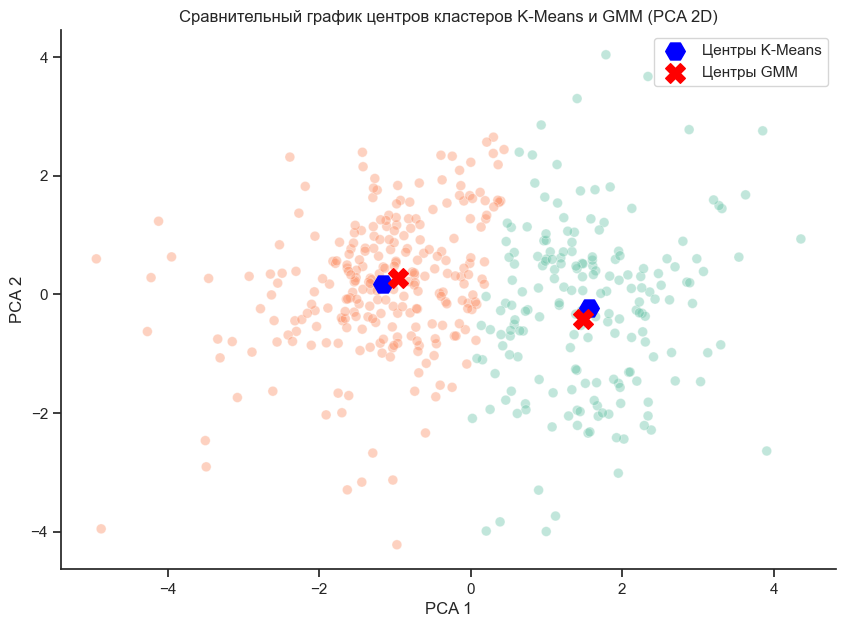

In [39]:
custom_palette = sns.color_palette(["#9f4c03"])
sns.set(style='ticks', palette=custom_palette)

# PCA для визуализации
pca = PCA(n_components=2)
pca_df = pca.fit_transform(df_scaled)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_df)
kmeans_centers = kmeans.cluster_centers_

# GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(pca_df)
gmm_centers = gmm.means_

# Визуализация
plt.figure(figsize=(10,7))

# Точки данных по K-Means
sns.scatterplot(x=pca_df[:,0], y=pca_df[:,1], hue=kmeans_labels, palette='Set2', alpha=0.4, s=50, legend=False)

# Центры K-Means
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], marker='H', s=200, c='blue', label='Центры K-Means')

# Центры GMM
plt.scatter(gmm_centers[:,0], gmm_centers[:,1], marker='X', s=200, c='red', label='Центры GMM')

plt.title("Сравнительный график центров кластеров K-Means и GMM (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
sns.despine()
plt.show()